In [ ]:
"""
@author: Maziar Raissi
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

np.random.seed(1234)
tf.random.set_seed(1234)

In [ ]:
import tensorflow as tf
import numpy as np
import time

class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, u, v, layers):
        X = np.concatenate([x, y, t], 1)

        self.lb = X.min(0)
        self.ub = X.max(0)

        self.X = X

        self.x = X[:, 0:1]
        self.y = X[:, 1:2]
        self.t = X[:, 2:3]

        self.u = u
        self.v = v

        self.layers = layers

        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)

        # Set lambda_1 and lambda_2 to 1
        self.lambda_1 = 1.0
        self.lambda_2 = 1.0

        # Convert data to tensors
        self.x_tf = tf.convert_to_tensor(self.x, dtype=tf.float32)
        self.y_tf = tf.convert_to_tensor(self.y, dtype=tf.float32)
        self.t_tf = tf.convert_to_tensor(self.t, dtype=tf.float32)

        self.u_tf = tf.convert_to_tensor(self.u, dtype=tf.float32)
        self.v_tf = tf.convert_to_tensor(self.v, dtype=tf.float32)

        # Define optimizer
        self.optimizer_Adam = tf.optimizers.Adam()

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_NS(self, x, y, t):
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2

        with tf.GradientTape(persistent=True) as tape:
            tape.watch([x, y, t])
            psi_and_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
            psi = psi_and_p[:, 0:1]
            p = psi_and_p[:, 1:2]

            u = tape.gradient(psi, y)
            v = -tape.gradient(psi, x)

            u_t = tape.gradient(u, t)
            u_x = tape.gradient(u, x)
            u_y = tape.gradient(u, y)
            u_xx = tape.gradient(u_x, x)
            u_yy = tape.gradient(u_y, y)

            v_t = tape.gradient(v, t)
            v_x = tape.gradient(v, x)
            v_y = tape.gradient(v, y)
            v_xx = tape.gradient(v_x, x)
            v_yy = tape.gradient(v_y, y)

            p_x = tape.gradient(p, x)
            p_y = tape.gradient(p, y)

        f_u = u_t + lambda_1 * (u * u_x + v * u_y) + p_x - lambda_2 * (u_xx + u_yy)
        f_v = v_t + lambda_1 * (u * v_x + v * v_y) + p_y - lambda_2 * (v_xx + v_yy)

        del tape  # Make sure to delete the tape to free memory

        return u, v, p, f_u, f_v

    def compute_loss(self):
        u_pred, v_pred, p_pred, f_u_pred, f_v_pred = self.net_NS(self.x_tf, self.y_tf, self.t_tf)

        loss = tf.reduce_sum(tf.square(self.u_tf - u_pred)) + \
               tf.reduce_sum(tf.square(self.v_tf - v_pred)) + \
               tf.reduce_sum(tf.square(f_u_pred)) + \
               tf.reduce_sum(tf.square(f_v_pred))
        return loss

    def callback(self, loss):
        print('Loss: %.3e' % (loss))

    def train(self, nIter):
        start_time = time.time()
        for it in range(nIter):
            with tf.GradientTape() as tape:
                loss_value = self.compute_loss()
            trainable_variables = self.weights + self.biases
            grads = tape.gradient(loss_value, trainable_variables)
            self.optimizer_Adam.apply_gradients(zip(grads, trainable_variables))

            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                print('It: %d, Loss: %.3e, Time: %.2f' %
                      (it, loss_value, elapsed))
                start_time = time.time()

    def predict(self, x_star, y_star, t_star):
        x_star_tf = tf.convert_to_tensor(x_star, dtype=tf.float32)
        y_star_tf = tf.convert_to_tensor(y_star, dtype=tf.float32)
        t_star_tf = tf.convert_to_tensor(t_star, dtype=tf.float32)

        u_star, v_star, p_star, _, _ = self.net_NS(x_star_tf, y_star_tf, t_star_tf)

        return u_star.numpy(), v_star.numpy(), p_star.numpy()


In [ ]:
# Data loading and preprocessing
import sys
sys.path.insert(0, '../../Utilities/')
data = scipy.io.loadmat('cylinder_nektar_wake.mat')

U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

# Rearrange Data
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

# Noiseless Data
N_train = 5000
idx = np.random.choice(N*T, N_train, replace=False)
x_train = tf.convert_to_tensor(x[idx,:], dtype=tf.float32)
y_train = tf.convert_to_tensor(y[idx,:], dtype=tf.float32)
t_train = tf.convert_to_tensor(t[idx,:], dtype=tf.float32)
u_train = tf.convert_to_tensor(u[idx,:], dtype=tf.float32)
v_train = tf.convert_to_tensor(v[idx,:], dtype=tf.float32)

# Training
layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
model = PhysicsInformedNN(x_train, y_train, t_train, u_train, v_train, layers)
model.train(200000)

# Test Data
snap = np.array([100])
x_star = tf.convert_to_tensor(X_star[:,0:1], dtype=tf.float32)
y_star = tf.convert_to_tensor(X_star[:,1:2], dtype=tf.float32)
t_star = tf.convert_to_tensor(TT[:,snap], dtype=tf.float32)

u_star = U_star[:,0,snap]
v_star = U_star[:,1,snap]
p_star = P_star[:,snap]

# Prediction
u_pred, v_pred, p_pred = model.predict(x_star, y_star, t_star)
lambda_1_value = model.lambda_1.numpy()[0]
lambda_2_value = model.lambda_2.numpy()[0]

# Error
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)

error_lambda_1 = np.abs(lambda_1_value - 1.0)*100
error_lambda_2 = np.abs(lambda_2_value - 0.01)/0.01 * 100

print(f'Error u: {error_u:e}')
print(f'Error v: {error_v:e}')
print(f'Error p: {error_p:e}')
print(f'Error l1: {error_lambda_1:.5f}%')
print(f'Error l2: {error_lambda_2:.5f}%')

It: 0, Loss: 4.240e+03, l1: 0.001, l2: -0.00100, Time: 3.67


It: 10, Loss: 2.851e+03, l1: -0.006, l2: -0.01079, Time: 6.16


It: 20, Loss: 2.029e+03, l1: -0.004, l2: -0.01609, Time: 6.95


It: 30, Loss: 1.647e+03, l1: 0.001, l2: -0.00830, Time: 6.25


It: 40, Loss: 1.380e+03, l1: -0.010, l2: -0.00926, Time: 6.94


It: 50, Loss: 1.215e+03, l1: -0.023, l2: -0.01642, Time: 6.39


It: 60, Loss: 1.101e+03, l1: -0.031, l2: -0.02223, Time: 6.71


It: 70, Loss: 1.025e+03, l1: -0.025, l2: -0.02209, Time: 7.11


It: 80, Loss: 9.590e+02, l1: -0.013, l2: -0.01856, Time: 6.62


It: 90, Loss: 8.956e+02, l1: -0.001, l2: -0.01552, Time: 7.35


It: 100, Loss: 8.320e+02, l1: 0.008, l2: -0.01335, Time: 6.52


It: 110, Loss: 7.676e+02, l1: 0.015, l2: -0.01123, Time: 7.26


It: 120, Loss: 7.070e+02, l1: 0.022, l2: -0.00866, Time: 6.44


It: 130, Loss: 6.601e+02, l1: 0.030, l2: -0.00531, Time: 7.13


It: 140, Loss: 6.343e+02, l1: 0.038, l2: -0.00122, Time: 6.41


It: 150, Loss: 6.228e+02, l1: 0.044, l2: 0.00231, Time: 7.32


It: 160, Loss: 6.121e+02, l1: 0.047, l2: 0.00373, Time: 6.45


It: 170, Loss: 6.007e+02, l1: 0.048, l2: 0.00270, Time: 7.00


It: 180, Loss: 5.922e+02, l1: 0.045, l2: 0.00218, Time: 7.04


It: 190, Loss: 5.813e+02, l1: 0.041, l2: 0.00232, Time: 6.65


It: 200, Loss: 5.707e+02, l1: 0.038, l2: 0.00277, Time: 7.10


It: 210, Loss: 5.613e+02, l1: 0.037, l2: 0.00243, Time: 6.42


It: 220, Loss: 5.559e+02, l1: 0.034, l2: 0.00240, Time: 7.24


It: 230, Loss: 5.493e+02, l1: 0.031, l2: 0.00226, Time: 6.42


It: 240, Loss: 5.429e+02, l1: 0.028, l2: 0.00212, Time: 7.32


It: 250, Loss: 5.405e+02, l1: 0.024, l2: 0.00204, Time: 6.46


It: 260, Loss: 5.355e+02, l1: 0.020, l2: 0.00191, Time: 8.34


It: 270, Loss: 5.328e+02, l1: 0.017, l2: 0.00178, Time: 6.46


It: 280, Loss: 5.304e+02, l1: 0.014, l2: 0.00168, Time: 7.32


It: 290, Loss: 5.284e+02, l1: 0.011, l2: 0.00158, Time: 7.01


It: 300, Loss: 5.262e+02, l1: 0.009, l2: 0.00154, Time: 6.71


It: 310, Loss: 5.301e+02, l1: 0.008, l2: 0.00158, Time: 7.13


It: 320, Loss: 5.231e+02, l1: 0.007, l2: 0.00154, Time: 6.49


It: 330, Loss: 5.217e+02, l1: 0.006, l2: 0.00157, Time: 7.26


It: 340, Loss: 5.198e+02, l1: 0.006, l2: 0.00161, Time: 6.27


It: 350, Loss: 5.180e+02, l1: 0.006, l2: 0.00161, Time: 7.24


It: 360, Loss: 5.205e+02, l1: 0.005, l2: 0.00160, Time: 6.46


It: 370, Loss: 5.158e+02, l1: 0.004, l2: 0.00151, Time: 7.39


It: 380, Loss: 5.123e+02, l1: 0.002, l2: 0.00135, Time: 6.76


It: 390, Loss: 5.094e+02, l1: 0.000, l2: 0.00115, Time: 7.35


It: 400, Loss: 5.082e+02, l1: -0.003, l2: 0.00100, Time: 7.34


It: 410, Loss: 5.073e+02, l1: -0.008, l2: 0.00068, Time: 6.51


It: 420, Loss: 5.026e+02, l1: -0.015, l2: 0.00024, Time: 7.22


It: 430, Loss: 5.017e+02, l1: -0.022, l2: -0.00018, Time: 6.50


It: 440, Loss: 4.981e+02, l1: -0.030, l2: -0.00061, Time: 7.32


It: 450, Loss: 5.030e+02, l1: -0.038, l2: -0.00099, Time: 6.52


It: 460, Loss: 4.975e+02, l1: -0.043, l2: -0.00137, Time: 7.27


It: 470, Loss: 4.956e+02, l1: -0.048, l2: -0.00158, Time: 6.79


It: 480, Loss: 4.925e+02, l1: -0.053, l2: -0.00181, Time: 7.05


It: 490, Loss: 4.903e+02, l1: -0.058, l2: -0.00188, Time: 7.36


It: 500, Loss: 4.887e+02, l1: -0.063, l2: -0.00187, Time: 6.61


It: 510, Loss: 5.076e+02, l1: -0.065, l2: -0.00164, Time: 7.38


It: 520, Loss: 4.972e+02, l1: -0.059, l2: -0.00161, Time: 6.53


It: 530, Loss: 4.854e+02, l1: -0.055, l2: -0.00146, Time: 7.20


It: 540, Loss: 4.863e+02, l1: -0.051, l2: -0.00115, Time: 7.07


It: 550, Loss: 4.837e+02, l1: -0.048, l2: -0.00084, Time: 7.59


It: 560, Loss: 4.828e+02, l1: -0.044, l2: -0.00057, Time: 7.06


It: 570, Loss: 4.820e+02, l1: -0.040, l2: -0.00027, Time: 6.90


It: 580, Loss: 4.974e+02, l1: -0.036, l2: 0.00009, Time: 7.16


It: 590, Loss: 4.820e+02, l1: -0.028, l2: 0.00029, Time: 6.32


It: 600, Loss: 4.800e+02, l1: -0.022, l2: 0.00057, Time: 7.09


It: 610, Loss: 4.799e+02, l1: -0.016, l2: 0.00086, Time: 6.26


It: 620, Loss: 4.789e+02, l1: -0.011, l2: 0.00113, Time: 7.05


It: 630, Loss: 4.782e+02, l1: -0.006, l2: 0.00135, Time: 6.29


It: 640, Loss: 4.838e+02, l1: -0.002, l2: 0.00157, Time: 7.12


It: 650, Loss: 4.922e+02, l1: 0.001, l2: 0.00154, Time: 6.24


It: 660, Loss: 4.794e+02, l1: 0.006, l2: 0.00174, Time: 7.18


It: 670, Loss: 4.772e+02, l1: 0.012, l2: 0.00192, Time: 6.50


It: 680, Loss: 4.771e+02, l1: 0.016, l2: 0.00211, Time: 6.91


It: 690, Loss: 4.764e+02, l1: 0.019, l2: 0.00221, Time: 6.83


It: 700, Loss: 4.762e+02, l1: 0.021, l2: 0.00227, Time: 6.71


It: 710, Loss: 4.759e+02, l1: 0.023, l2: 0.00232, Time: 7.28


It: 720, Loss: 4.756e+02, l1: 0.024, l2: 0.00235, Time: 6.28


It: 730, Loss: 4.802e+02, l1: 0.025, l2: 0.00236, Time: 7.18


It: 740, Loss: 4.871e+02, l1: 0.024, l2: 0.00224, Time: 6.27


It: 750, Loss: 4.793e+02, l1: 0.025, l2: 0.00220, Time: 7.14


It: 760, Loss: 4.757e+02, l1: 0.029, l2: 0.00229, Time: 6.32


It: 770, Loss: 4.751e+02, l1: 0.033, l2: 0.00240, Time: 7.19


It: 780, Loss: 4.748e+02, l1: 0.034, l2: 0.00243, Time: 6.20


It: 790, Loss: 4.747e+02, l1: 0.034, l2: 0.00243, Time: 7.12


It: 800, Loss: 4.745e+02, l1: 0.034, l2: 0.00240, Time: 6.39


It: 810, Loss: 4.744e+02, l1: 0.034, l2: 0.00237, Time: 7.26


It: 820, Loss: 4.743e+02, l1: 0.033, l2: 0.00233, Time: 6.76


It: 830, Loss: 4.741e+02, l1: 0.033, l2: 0.00229, Time: 6.86


It: 840, Loss: 4.741e+02, l1: 0.033, l2: 0.00225, Time: 7.97


It: 850, Loss: 4.843e+02, l1: 0.032, l2: 0.00220, Time: 6.77


It: 860, Loss: 4.829e+02, l1: 0.029, l2: 0.00199, Time: 8.04


It: 870, Loss: 4.761e+02, l1: 0.029, l2: 0.00192, Time: 6.41


It: 880, Loss: 4.739e+02, l1: 0.033, l2: 0.00198, Time: 7.33


It: 890, Loss: 4.738e+02, l1: 0.034, l2: 0.00202, Time: 6.39


It: 900, Loss: 4.736e+02, l1: 0.033, l2: 0.00199, Time: 7.15


It: 910, Loss: 4.734e+02, l1: 0.031, l2: 0.00194, Time: 6.33


It: 920, Loss: 4.733e+02, l1: 0.030, l2: 0.00188, Time: 7.18


It: 930, Loss: 4.732e+02, l1: 0.030, l2: 0.00182, Time: 6.66


It: 940, Loss: 4.731e+02, l1: 0.029, l2: 0.00176, Time: 7.40


It: 950, Loss: 4.730e+02, l1: 0.028, l2: 0.00171, Time: 7.59


It: 960, Loss: 4.729e+02, l1: 0.027, l2: 0.00165, Time: 6.76


It: 970, Loss: 4.729e+02, l1: 0.027, l2: 0.00160, Time: 7.65


It: 980, Loss: 4.729e+02, l1: 0.026, l2: 0.00155, Time: 6.73


It: 990, Loss: 4.997e+02, l1: 0.025, l2: 0.00139, Time: 7.43


It: 1000, Loss: 4.744e+02, l1: 0.024, l2: 0.00130, Time: 6.78


It: 1010, Loss: 4.737e+02, l1: 0.024, l2: 0.00134, Time: 7.29


It: 1020, Loss: 4.733e+02, l1: 0.025, l2: 0.00137, Time: 7.44


It: 1030, Loss: 4.728e+02, l1: 0.024, l2: 0.00131, Time: 6.68


It: 1040, Loss: 4.724e+02, l1: 0.022, l2: 0.00121, Time: 7.31


It: 1050, Loss: 4.723e+02, l1: 0.020, l2: 0.00113, Time: 6.80


It: 1060, Loss: 4.722e+02, l1: 0.019, l2: 0.00108, Time: 7.66


It: 1070, Loss: 4.722e+02, l1: 0.019, l2: 0.00104, Time: 6.65


It: 1080, Loss: 4.721e+02, l1: 0.018, l2: 0.00099, Time: 7.60


It: 1090, Loss: 4.720e+02, l1: 0.017, l2: 0.00094, Time: 7.13


It: 1100, Loss: 4.719e+02, l1: 0.017, l2: 0.00090, Time: 6.98


It: 1110, Loss: 4.718e+02, l1: 0.016, l2: 0.00086, Time: 7.57


It: 1120, Loss: 4.718e+02, l1: 0.016, l2: 0.00082, Time: 6.56


It: 1130, Loss: 4.721e+02, l1: 0.015, l2: 0.00077, Time: 8.63


It: 1140, Loss: 4.978e+02, l1: 0.016, l2: 0.00063, Time: 6.67


It: 1150, Loss: 4.772e+02, l1: 0.016, l2: 0.00089, Time: 7.37


It: 1160, Loss: 4.733e+02, l1: 0.017, l2: 0.00078, Time: 6.58


It: 1170, Loss: 4.718e+02, l1: 0.015, l2: 0.00060, Time: 7.36


It: 1180, Loss: 4.717e+02, l1: 0.013, l2: 0.00051, Time: 6.96


It: 1190, Loss: 4.715e+02, l1: 0.010, l2: 0.00047, Time: 7.04


It: 1200, Loss: 4.714e+02, l1: 0.009, l2: 0.00040, Time: 7.48


It: 1210, Loss: 4.713e+02, l1: 0.008, l2: 0.00037, Time: 6.60


It: 1220, Loss: 4.712e+02, l1: 0.008, l2: 0.00035, Time: 7.46


It: 1230, Loss: 4.712e+02, l1: 0.008, l2: 0.00033, Time: 6.59


It: 1240, Loss: 4.711e+02, l1: 0.007, l2: 0.00030, Time: 7.51


It: 1250, Loss: 4.710e+02, l1: 0.007, l2: 0.00028, Time: 6.69


It: 1260, Loss: 4.710e+02, l1: 0.007, l2: 0.00026, Time: 7.49


It: 1270, Loss: 4.709e+02, l1: 0.006, l2: 0.00023, Time: 7.32


It: 1280, Loss: 4.708e+02, l1: 0.006, l2: 0.00020, Time: 6.68


It: 1290, Loss: 4.709e+02, l1: 0.005, l2: 0.00018, Time: 7.10


It: 1300, Loss: 5.077e+02, l1: 0.006, l2: -0.00019, Time: 6.47


It: 1310, Loss: 4.764e+02, l1: 0.010, l2: 0.00034, Time: 7.41


It: 1320, Loss: 4.716e+02, l1: 0.009, l2: 0.00033, Time: 6.88


It: 1330, Loss: 4.718e+02, l1: 0.006, l2: 0.00005, Time: 7.36


It: 1340, Loss: 4.708e+02, l1: 0.002, l2: -0.00004, Time: 6.82


It: 1350, Loss: 4.707e+02, l1: -0.001, l2: -0.00010, Time: 7.21


It: 1360, Loss: 4.705e+02, l1: -0.002, l2: -0.00018, Time: 7.39


It: 1370, Loss: 4.704e+02, l1: -0.002, l2: -0.00016, Time: 6.63


It: 1380, Loss: 4.704e+02, l1: -0.002, l2: -0.00016, Time: 7.30


It: 1390, Loss: 4.703e+02, l1: -0.002, l2: -0.00017, Time: 6.57


It: 1400, Loss: 4.703e+02, l1: -0.003, l2: -0.00017, Time: 7.47


It: 1410, Loss: 4.702e+02, l1: -0.003, l2: -0.00018, Time: 6.77


It: 1420, Loss: 4.701e+02, l1: -0.003, l2: -0.00019, Time: 8.25


It: 1430, Loss: 4.701e+02, l1: -0.004, l2: -0.00021, Time: 7.44


It: 1440, Loss: 4.700e+02, l1: -0.004, l2: -0.00023, Time: 6.78


It: 1450, Loss: 4.700e+02, l1: -0.005, l2: -0.00025, Time: 7.51


It: 1460, Loss: 4.699e+02, l1: -0.005, l2: -0.00028, Time: 6.81


It: 1470, Loss: 4.701e+02, l1: -0.006, l2: -0.00030, Time: 7.53


It: 1480, Loss: 5.124e+02, l1: -0.002, l2: -0.00058, Time: 6.96


It: 1490, Loss: 4.742e+02, l1: 0.003, l2: 0.00023, Time: 7.14


It: 1500, Loss: 4.726e+02, l1: 0.001, l2: -0.00030, Time: 7.29


It: 1510, Loss: 4.710e+02, l1: -0.005, l2: -0.00034, Time: 6.59


It: 1520, Loss: 4.701e+02, l1: -0.011, l2: -0.00051, Time: 8.44


It: 1530, Loss: 4.697e+02, l1: -0.014, l2: -0.00068, Time: 8.46


It: 1540, Loss: 4.697e+02, l1: -0.015, l2: -0.00064, Time: 7.13


It: 1550, Loss: 4.696e+02, l1: -0.015, l2: -0.00064, Time: 7.16


It: 1560, Loss: 4.695e+02, l1: -0.014, l2: -0.00060, Time: 6.61


It: 1570, Loss: 4.694e+02, l1: -0.014, l2: -0.00059, Time: 7.41


It: 1580, Loss: 4.694e+02, l1: -0.014, l2: -0.00058, Time: 6.48


It: 1590, Loss: 4.693e+02, l1: -0.014, l2: -0.00058, Time: 7.44


It: 1600, Loss: 4.692e+02, l1: -0.014, l2: -0.00059, Time: 6.51


It: 1610, Loss: 4.692e+02, l1: -0.015, l2: -0.00060, Time: 7.27


It: 1620, Loss: 4.691e+02, l1: -0.015, l2: -0.00062, Time: 6.89


It: 1630, Loss: 4.691e+02, l1: -0.016, l2: -0.00064, Time: 7.32


It: 1640, Loss: 4.690e+02, l1: -0.017, l2: -0.00066, Time: 7.53


It: 1650, Loss: 4.689e+02, l1: -0.017, l2: -0.00068, Time: 6.54


It: 1660, Loss: 4.689e+02, l1: -0.018, l2: -0.00070, Time: 7.39


It: 1670, Loss: 4.688e+02, l1: -0.018, l2: -0.00072, Time: 6.53


It: 1680, Loss: 4.688e+02, l1: -0.019, l2: -0.00074, Time: 7.42


It: 1690, Loss: 4.997e+02, l1: -0.015, l2: -0.00113, Time: 6.66


It: 1700, Loss: 4.801e+02, l1: -0.006, l2: -0.00009, Time: 7.58


It: 1710, Loss: 4.716e+02, l1: -0.010, l2: -0.00057, Time: 8.29


It: 1720, Loss: 4.694e+02, l1: -0.016, l2: -0.00064, Time: 6.61


It: 1730, Loss: 4.687e+02, l1: -0.021, l2: -0.00082, Time: 7.47


It: 1740, Loss: 4.686e+02, l1: -0.024, l2: -0.00092, Time: 6.64


It: 1750, Loss: 4.685e+02, l1: -0.024, l2: -0.00090, Time: 7.30


It: 1760, Loss: 4.684e+02, l1: -0.023, l2: -0.00087, Time: 6.52


It: 1770, Loss: 4.683e+02, l1: -0.022, l2: -0.00081, Time: 7.41


It: 1780, Loss: 4.682e+02, l1: -0.021, l2: -0.00077, Time: 6.81


It: 1790, Loss: 4.682e+02, l1: -0.020, l2: -0.00074, Time: 7.17


It: 1800, Loss: 4.681e+02, l1: -0.019, l2: -0.00072, Time: 6.86


It: 1810, Loss: 4.680e+02, l1: -0.019, l2: -0.00072, Time: 6.74


It: 1820, Loss: 4.680e+02, l1: -0.019, l2: -0.00071, Time: 7.36


It: 1830, Loss: 4.680e+02, l1: -0.019, l2: -0.00071, Time: 6.54


It: 1840, Loss: 4.844e+02, l1: -0.017, l2: -0.00083, Time: 7.22


It: 1850, Loss: 4.753e+02, l1: -0.009, l2: -0.00080, Time: 6.45


It: 1860, Loss: 4.680e+02, l1: -0.010, l2: -0.00039, Time: 7.07


It: 1870, Loss: 4.690e+02, l1: -0.015, l2: -0.00076, Time: 6.72


It: 1880, Loss: 4.681e+02, l1: -0.019, l2: -0.00076, Time: 7.26


It: 1890, Loss: 4.677e+02, l1: -0.020, l2: -0.00082, Time: 7.04


It: 1900, Loss: 4.676e+02, l1: -0.019, l2: -0.00074, Time: 6.49


It: 1910, Loss: 4.676e+02, l1: -0.017, l2: -0.00066, Time: 7.24


It: 1920, Loss: 4.675e+02, l1: -0.015, l2: -0.00059, Time: 6.62


It: 1930, Loss: 4.674e+02, l1: -0.013, l2: -0.00052, Time: 7.37


It: 1940, Loss: 4.674e+02, l1: -0.012, l2: -0.00048, Time: 6.45


It: 1950, Loss: 4.673e+02, l1: -0.011, l2: -0.00045, Time: 7.45


It: 1960, Loss: 4.673e+02, l1: -0.010, l2: -0.00044, Time: 7.15


It: 1970, Loss: 4.672e+02, l1: -0.010, l2: -0.00042, Time: 6.89


It: 1980, Loss: 4.672e+02, l1: -0.009, l2: -0.00040, Time: 7.16


It: 1990, Loss: 4.671e+02, l1: -0.008, l2: -0.00038, Time: 6.43


It: 2000, Loss: 4.676e+02, l1: -0.007, l2: -0.00036, Time: 7.97


It: 2010, Loss: 4.903e+02, l1: -0.001, l2: -0.00038, Time: 6.50


It: 2020, Loss: 4.721e+02, l1: 0.003, l2: -0.00006, Time: 7.44


It: 2030, Loss: 4.686e+02, l1: -0.001, l2: -0.00012, Time: 6.45


It: 2040, Loss: 4.677e+02, l1: -0.006, l2: -0.00046, Time: 7.24


It: 2050, Loss: 4.670e+02, l1: -0.008, l2: -0.00037, Time: 7.20


It: 2060, Loss: 4.670e+02, l1: -0.008, l2: -0.00043, Time: 7.01


It: 2070, Loss: 4.669e+02, l1: -0.006, l2: -0.00029, Time: 7.37


It: 2080, Loss: 4.668e+02, l1: -0.004, l2: -0.00024, Time: 6.60


It: 2090, Loss: 4.668e+02, l1: -0.002, l2: -0.00020, Time: 7.44


It: 2100, Loss: 4.668e+02, l1: -0.001, l2: -0.00016, Time: 6.44


It: 2110, Loss: 4.667e+02, l1: -0.001, l2: -0.00016, Time: 7.35


It: 2120, Loss: 4.667e+02, l1: -0.001, l2: -0.00015, Time: 6.67


It: 2130, Loss: 4.666e+02, l1: -0.001, l2: -0.00015, Time: 6.86


It: 2140, Loss: 4.666e+02, l1: -0.000, l2: -0.00015, Time: 7.24


It: 2150, Loss: 4.667e+02, l1: -0.000, l2: -0.00014, Time: 6.36


It: 2160, Loss: 4.996e+02, l1: 0.003, l2: -0.00053, Time: 7.43


It: 2170, Loss: 4.703e+02, l1: 0.009, l2: 0.00058, Time: 6.77


It: 2180, Loss: 4.676e+02, l1: 0.005, l2: -0.00029, Time: 7.20


It: 2190, Loss: 4.677e+02, l1: -0.001, l2: -0.00009, Time: 6.46


It: 2200, Loss: 4.666e+02, l1: -0.003, l2: -0.00035, Time: 7.28


It: 2210, Loss: 4.665e+02, l1: -0.003, l2: -0.00023, Time: 6.99


It: 2220, Loss: 4.665e+02, l1: -0.001, l2: -0.00015, Time: 7.13


It: 2230, Loss: 4.664e+02, l1: 0.001, l2: -0.00011, Time: 7.04


It: 2240, Loss: 4.663e+02, l1: 0.002, l2: -0.00004, Time: 6.39


It: 2250, Loss: 4.663e+02, l1: 0.003, l2: -0.00004, Time: 7.28


It: 2260, Loss: 4.662e+02, l1: 0.003, l2: -0.00003, Time: 6.58


It: 2270, Loss: 4.662e+02, l1: 0.003, l2: -0.00004, Time: 7.33


It: 2280, Loss: 4.661e+02, l1: 0.003, l2: -0.00004, Time: 6.58


It: 2290, Loss: 4.661e+02, l1: 0.004, l2: -0.00004, Time: 7.16


It: 2300, Loss: 4.660e+02, l1: 0.004, l2: -0.00004, Time: 7.93


It: 2310, Loss: 4.660e+02, l1: 0.004, l2: -0.00004, Time: 6.62


It: 2320, Loss: 4.682e+02, l1: 0.004, l2: -0.00010, Time: 7.37


It: 2330, Loss: 4.676e+02, l1: 0.011, l2: 0.00052, Time: 6.37


It: 2340, Loss: 4.697e+02, l1: 0.010, l2: -0.00004, Time: 7.24


It: 2350, Loss: 4.663e+02, l1: 0.005, l2: -0.00006, Time: 6.56


It: 2360, Loss: 4.666e+02, l1: 0.001, l2: -0.00021, Time: 7.37


It: 2370, Loss: 4.660e+02, l1: 0.001, l2: -0.00021, Time: 6.52


It: 2380, Loss: 4.658e+02, l1: 0.002, l2: -0.00006, Time: 7.56


It: 2390, Loss: 4.658e+02, l1: 0.004, l2: -0.00004, Time: 7.22


It: 2400, Loss: 4.657e+02, l1: 0.006, l2: 0.00003, Time: 6.49


It: 2410, Loss: 4.656e+02, l1: 0.007, l2: 0.00004, Time: 7.41


It: 2420, Loss: 4.656e+02, l1: 0.007, l2: 0.00004, Time: 6.37


It: 2430, Loss: 4.655e+02, l1: 0.007, l2: 0.00004, Time: 7.32


It: 2440, Loss: 4.655e+02, l1: 0.007, l2: 0.00003, Time: 6.55


It: 2450, Loss: 4.654e+02, l1: 0.007, l2: 0.00003, Time: 7.12


It: 2460, Loss: 4.654e+02, l1: 0.007, l2: 0.00003, Time: 6.46


It: 2470, Loss: 4.653e+02, l1: 0.008, l2: 0.00003, Time: 7.31


It: 2480, Loss: 4.653e+02, l1: 0.008, l2: 0.00004, Time: 7.00


It: 2490, Loss: 4.667e+02, l1: 0.008, l2: 0.00005, Time: 6.81


It: 2500, Loss: 4.723e+02, l1: 0.015, l2: 0.00058, Time: 7.33


It: 2510, Loss: 4.701e+02, l1: 0.014, l2: 0.00012, Time: 6.61


It: 2520, Loss: 4.654e+02, l1: 0.010, l2: 0.00007, Time: 7.41


It: 2530, Loss: 4.657e+02, l1: 0.006, l2: 0.00001, Time: 6.54


It: 2540, Loss: 4.652e+02, l1: 0.006, l2: -0.00008, Time: 7.24


It: 2550, Loss: 4.650e+02, l1: 0.008, l2: 0.00004, Time: 6.71


It: 2560, Loss: 4.649e+02, l1: 0.009, l2: 0.00008, Time: 7.05


It: 2570, Loss: 4.648e+02, l1: 0.010, l2: 0.00010, Time: 7.37


It: 2580, Loss: 4.648e+02, l1: 0.011, l2: 0.00012, Time: 6.52


It: 2590, Loss: 4.659e+02, l1: 0.011, l2: 0.00007, Time: 7.32


It: 2600, Loss: 4.748e+02, l1: 0.014, l2: 0.00014, Time: 7.29


It: 2610, Loss: 4.690e+02, l1: 0.013, l2: -0.00008, Time: 7.33


It: 2620, Loss: 4.648e+02, l1: 0.010, l2: 0.00012, Time: 6.57


It: 2630, Loss: 4.648e+02, l1: 0.007, l2: -0.00014, Time: 7.22


It: 2640, Loss: 4.647e+02, l1: 0.008, l2: 0.00005, Time: 6.98


It: 2650, Loss: 4.645e+02, l1: 0.010, l2: 0.00005, Time: 6.86


It: 2660, Loss: 4.644e+02, l1: 0.012, l2: 0.00016, Time: 7.29


It: 2670, Loss: 4.643e+02, l1: 0.014, l2: 0.00016, Time: 6.55


It: 2680, Loss: 4.642e+02, l1: 0.014, l2: 0.00018, Time: 7.35


It: 2690, Loss: 4.641e+02, l1: 0.015, l2: 0.00019, Time: 6.60


It: 2700, Loss: 4.640e+02, l1: 0.015, l2: 0.00019, Time: 7.51


It: 2710, Loss: 4.639e+02, l1: 0.016, l2: 0.00019, Time: 6.46


It: 2720, Loss: 4.639e+02, l1: 0.016, l2: 0.00019, Time: 7.20


It: 2730, Loss: 4.641e+02, l1: 0.017, l2: 0.00017, Time: 6.93


It: 2740, Loss: 4.926e+02, l1: 0.020, l2: -0.00027, Time: 6.88


It: 2750, Loss: 4.682e+02, l1: 0.022, l2: 0.00062, Time: 7.41


It: 2760, Loss: 4.648e+02, l1: 0.018, l2: -0.00003, Time: 6.53


It: 2770, Loss: 4.641e+02, l1: 0.015, l2: 0.00019, Time: 7.38


It: 2780, Loss: 4.638e+02, l1: 0.016, l2: 0.00012, Time: 6.52


It: 2790, Loss: 4.635e+02, l1: 0.018, l2: 0.00027, Time: 7.24


It: 2800, Loss: 4.633e+02, l1: 0.021, l2: 0.00032, Time: 6.40


It: 2810, Loss: 4.632e+02, l1: 0.022, l2: 0.00036, Time: 7.11


It: 2820, Loss: 4.631e+02, l1: 0.023, l2: 0.00036, Time: 6.56


It: 2830, Loss: 4.629e+02, l1: 0.024, l2: 0.00038, Time: 6.91


It: 2840, Loss: 4.628e+02, l1: 0.025, l2: 0.00039, Time: 7.31


It: 2850, Loss: 4.627e+02, l1: 0.026, l2: 0.00041, Time: 6.39


It: 2860, Loss: 4.626e+02, l1: 0.027, l2: 0.00042, Time: 7.23


It: 2870, Loss: 4.626e+02, l1: 0.028, l2: 0.00046, Time: 6.49


It: 2880, Loss: 4.824e+02, l1: 0.029, l2: 0.00035, Time: 7.38


It: 2890, Loss: 4.655e+02, l1: 0.032, l2: 0.00008, Time: 6.32


It: 2900, Loss: 4.664e+02, l1: 0.031, l2: 0.00067, Time: 8.07


It: 2910, Loss: 4.634e+02, l1: 0.027, l2: 0.00045, Time: 6.61


It: 2920, Loss: 4.623e+02, l1: 0.028, l2: 0.00037, Time: 6.76


It: 2930, Loss: 4.623e+02, l1: 0.031, l2: 0.00059, Time: 7.09


It: 2940, Loss: 4.620e+02, l1: 0.033, l2: 0.00067, Time: 6.41


It: 2950, Loss: 4.618e+02, l1: 0.035, l2: 0.00067, Time: 7.32


It: 2960, Loss: 4.617e+02, l1: 0.037, l2: 0.00072, Time: 6.39


It: 2970, Loss: 4.616e+02, l1: 0.038, l2: 0.00074, Time: 7.15


It: 2980, Loss: 4.615e+02, l1: 0.039, l2: 0.00075, Time: 6.56


It: 2990, Loss: 4.614e+02, l1: 0.040, l2: 0.00078, Time: 7.29


It: 3000, Loss: 4.613e+02, l1: 0.041, l2: 0.00080, Time: 6.87


It: 3010, Loss: 4.612e+02, l1: 0.042, l2: 0.00083, Time: 6.95


It: 3020, Loss: 4.611e+02, l1: 0.044, l2: 0.00085, Time: 7.35


It: 3030, Loss: 4.616e+02, l1: 0.045, l2: 0.00086, Time: 6.50


It: 3040, Loss: 4.656e+02, l1: 0.043, l2: 0.00074, Time: 7.14


It: 3050, Loss: 4.617e+02, l1: 0.044, l2: 0.00084, Time: 6.46


It: 3060, Loss: 4.625e+02, l1: 0.046, l2: 0.00088, Time: 7.26


It: 3070, Loss: 4.609e+02, l1: 0.046, l2: 0.00093, Time: 6.50


It: 3080, Loss: 4.608e+02, l1: 0.047, l2: 0.00097, Time: 7.23


It: 3090, Loss: 4.605e+02, l1: 0.049, l2: 0.00101, Time: 6.49


It: 3100, Loss: 4.604e+02, l1: 0.050, l2: 0.00106, Time: 7.12


It: 3110, Loss: 4.603e+02, l1: 0.051, l2: 0.00108, Time: 7.46


It: 3120, Loss: 4.601e+02, l1: 0.052, l2: 0.00111, Time: 6.63


It: 3130, Loss: 4.600e+02, l1: 0.053, l2: 0.00112, Time: 7.27


It: 3140, Loss: 4.599e+02, l1: 0.054, l2: 0.00114, Time: 6.61


It: 3150, Loss: 4.606e+02, l1: 0.055, l2: 0.00111, Time: 7.37


It: 3160, Loss: 4.673e+02, l1: 0.051, l2: 0.00101, Time: 6.59


It: 3170, Loss: 4.615e+02, l1: 0.052, l2: 0.00147, Time: 7.34


It: 3180, Loss: 4.613e+02, l1: 0.052, l2: 0.00111, Time: 6.86


It: 3190, Loss: 4.600e+02, l1: 0.053, l2: 0.00106, Time: 7.12


It: 3200, Loss: 4.599e+02, l1: 0.056, l2: 0.00123, Time: 7.57


It: 3210, Loss: 4.595e+02, l1: 0.056, l2: 0.00133, Time: 7.19


It: 3220, Loss: 4.594e+02, l1: 0.058, l2: 0.00135, Time: 7.24


It: 3230, Loss: 4.593e+02, l1: 0.059, l2: 0.00134, Time: 6.32


It: 3240, Loss: 4.591e+02, l1: 0.060, l2: 0.00136, Time: 7.29


It: 3250, Loss: 4.591e+02, l1: 0.061, l2: 0.00139, Time: 6.53


It: 3260, Loss: 4.590e+02, l1: 0.062, l2: 0.00140, Time: 7.18


It: 3270, Loss: 4.589e+02, l1: 0.062, l2: 0.00141, Time: 6.43


It: 3280, Loss: 4.588e+02, l1: 0.063, l2: 0.00142, Time: 7.35


It: 3290, Loss: 4.587e+02, l1: 0.064, l2: 0.00144, Time: 6.49


It: 3300, Loss: 4.586e+02, l1: 0.064, l2: 0.00146, Time: 6.98


It: 3310, Loss: 4.585e+02, l1: 0.065, l2: 0.00148, Time: 7.23


It: 3320, Loss: 4.584e+02, l1: 0.066, l2: 0.00149, Time: 6.73


It: 3330, Loss: 4.583e+02, l1: 0.066, l2: 0.00151, Time: 7.28


It: 3340, Loss: 4.582e+02, l1: 0.067, l2: 0.00153, Time: 6.61


It: 3350, Loss: 4.586e+02, l1: 0.068, l2: 0.00151, Time: 7.51


It: 3360, Loss: 4.758e+02, l1: 0.058, l2: 0.00097, Time: 6.84


It: 3370, Loss: 4.645e+02, l1: 0.061, l2: 0.00156, Time: 7.38


It: 3380, Loss: 4.601e+02, l1: 0.065, l2: 0.00159, Time: 6.57


It: 3390, Loss: 4.591e+02, l1: 0.066, l2: 0.00171, Time: 7.38


It: 3400, Loss: 4.583e+02, l1: 0.067, l2: 0.00165, Time: 7.24


It: 3410, Loss: 4.579e+02, l1: 0.067, l2: 0.00167, Time: 6.81


It: 3420, Loss: 4.577e+02, l1: 0.070, l2: 0.00170, Time: 7.28


It: 3430, Loss: 4.577e+02, l1: 0.071, l2: 0.00172, Time: 6.50


It: 3440, Loss: 4.576e+02, l1: 0.072, l2: 0.00175, Time: 7.44


It: 3450, Loss: 4.575e+02, l1: 0.072, l2: 0.00176, Time: 6.54


It: 3460, Loss: 4.574e+02, l1: 0.073, l2: 0.00177, Time: 7.26


It: 3470, Loss: 4.573e+02, l1: 0.074, l2: 0.00178, Time: 6.67


It: 3480, Loss: 4.572e+02, l1: 0.074, l2: 0.00179, Time: 7.24


It: 3490, Loss: 4.571e+02, l1: 0.075, l2: 0.00180, Time: 6.80


It: 3500, Loss: 4.570e+02, l1: 0.075, l2: 0.00181, Time: 7.09


It: 3510, Loss: 4.570e+02, l1: 0.076, l2: 0.00183, Time: 7.72


It: 3520, Loss: 4.569e+02, l1: 0.076, l2: 0.00184, Time: 6.46


It: 3530, Loss: 4.568e+02, l1: 0.077, l2: 0.00185, Time: 7.33


It: 3540, Loss: 4.637e+02, l1: 0.077, l2: 0.00178, Time: 6.55


It: 3550, Loss: 4.678e+02, l1: 0.074, l2: 0.00180, Time: 7.33


It: 3560, Loss: 4.570e+02, l1: 0.075, l2: 0.00175, Time: 6.49


It: 3570, Loss: 4.577e+02, l1: 0.076, l2: 0.00182, Time: 7.07


It: 3580, Loss: 4.568e+02, l1: 0.077, l2: 0.00189, Time: 6.86


It: 3590, Loss: 4.565e+02, l1: 0.078, l2: 0.00191, Time: 6.76


It: 3600, Loss: 4.564e+02, l1: 0.078, l2: 0.00193, Time: 7.27


It: 3610, Loss: 4.563e+02, l1: 0.079, l2: 0.00195, Time: 6.46


It: 3620, Loss: 4.562e+02, l1: 0.080, l2: 0.00197, Time: 7.34


It: 3630, Loss: 4.562e+02, l1: 0.081, l2: 0.00198, Time: 6.33


It: 3640, Loss: 4.561e+02, l1: 0.081, l2: 0.00199, Time: 7.24


It: 3650, Loss: 4.560e+02, l1: 0.082, l2: 0.00201, Time: 6.45


It: 3660, Loss: 4.559e+02, l1: 0.082, l2: 0.00202, Time: 7.29


It: 3670, Loss: 4.559e+02, l1: 0.082, l2: 0.00204, Time: 6.68


It: 3680, Loss: 4.753e+02, l1: 0.081, l2: 0.00205, Time: 7.10


It: 3690, Loss: 4.570e+02, l1: 0.074, l2: 0.00178, Time: 7.22


It: 3700, Loss: 4.586e+02, l1: 0.079, l2: 0.00192, Time: 6.49


It: 3710, Loss: 4.571e+02, l1: 0.081, l2: 0.00203, Time: 7.20


It: 3720, Loss: 4.559e+02, l1: 0.083, l2: 0.00215, Time: 6.39


It: 3730, Loss: 4.557e+02, l1: 0.082, l2: 0.00211, Time: 7.10


It: 3740, Loss: 4.556e+02, l1: 0.084, l2: 0.00213, Time: 6.36


It: 3750, Loss: 4.555e+02, l1: 0.084, l2: 0.00214, Time: 7.19


It: 3760, Loss: 4.554e+02, l1: 0.085, l2: 0.00215, Time: 6.31


It: 3770, Loss: 4.553e+02, l1: 0.086, l2: 0.00216, Time: 7.10


It: 3780, Loss: 4.553e+02, l1: 0.086, l2: 0.00216, Time: 6.66


It: 3790, Loss: 4.552e+02, l1: 0.086, l2: 0.00216, Time: 7.02


It: 3800, Loss: 4.551e+02, l1: 0.087, l2: 0.00217, Time: 7.19


It: 3810, Loss: 4.551e+02, l1: 0.087, l2: 0.00217, Time: 7.27


It: 3820, Loss: 4.550e+02, l1: 0.087, l2: 0.00217, Time: 7.31


It: 3830, Loss: 4.549e+02, l1: 0.088, l2: 0.00218, Time: 6.57


It: 3840, Loss: 4.549e+02, l1: 0.088, l2: 0.00218, Time: 7.28


It: 3850, Loss: 4.548e+02, l1: 0.088, l2: 0.00219, Time: 6.38


It: 3860, Loss: 4.547e+02, l1: 0.089, l2: 0.00219, Time: 7.27


It: 3870, Loss: 4.571e+02, l1: 0.089, l2: 0.00215, Time: 6.60


It: 3880, Loss: 4.629e+02, l1: 0.084, l2: 0.00229, Time: 7.09


It: 3890, Loss: 4.599e+02, l1: 0.086, l2: 0.00216, Time: 7.22


It: 3900, Loss: 4.547e+02, l1: 0.088, l2: 0.00212, Time: 6.51


It: 3910, Loss: 4.551e+02, l1: 0.089, l2: 0.00218, Time: 7.26


It: 3920, Loss: 4.545e+02, l1: 0.089, l2: 0.00221, Time: 6.54


It: 3930, Loss: 4.544e+02, l1: 0.089, l2: 0.00222, Time: 7.23


It: 3940, Loss: 4.544e+02, l1: 0.090, l2: 0.00222, Time: 6.38


It: 3950, Loss: 4.543e+02, l1: 0.091, l2: 0.00223, Time: 7.32


It: 3960, Loss: 4.542e+02, l1: 0.091, l2: 0.00224, Time: 6.52


It: 3970, Loss: 4.542e+02, l1: 0.091, l2: 0.00224, Time: 7.28


It: 3980, Loss: 4.542e+02, l1: 0.091, l2: 0.00224, Time: 7.14


It: 3990, Loss: 4.870e+02, l1: 0.088, l2: 0.00194, Time: 6.49


It: 4000, Loss: 4.615e+02, l1: 0.082, l2: 0.00189, Time: 7.22


It: 4010, Loss: 4.546e+02, l1: 0.088, l2: 0.00220, Time: 6.45


It: 4020, Loss: 4.542e+02, l1: 0.091, l2: 0.00229, Time: 7.40


It: 4030, Loss: 4.542e+02, l1: 0.093, l2: 0.00234, Time: 6.50


It: 4040, Loss: 4.541e+02, l1: 0.091, l2: 0.00230, Time: 7.46


It: 4050, Loss: 4.539e+02, l1: 0.093, l2: 0.00230, Time: 6.69


It: 4060, Loss: 4.538e+02, l1: 0.093, l2: 0.00230, Time: 7.31


It: 4070, Loss: 4.537e+02, l1: 0.094, l2: 0.00230, Time: 6.91


It: 4080, Loss: 4.537e+02, l1: 0.094, l2: 0.00230, Time: 7.05


It: 4090, Loss: 4.536e+02, l1: 0.094, l2: 0.00230, Time: 7.33


It: 4100, Loss: 4.536e+02, l1: 0.094, l2: 0.00229, Time: 6.45


It: 4110, Loss: 4.535e+02, l1: 0.095, l2: 0.00229, Time: 7.52


It: 4120, Loss: 4.534e+02, l1: 0.095, l2: 0.00229, Time: 7.48


It: 4130, Loss: 4.534e+02, l1: 0.095, l2: 0.00229, Time: 7.28


It: 4140, Loss: 4.533e+02, l1: 0.095, l2: 0.00229, Time: 6.74


It: 4150, Loss: 4.533e+02, l1: 0.096, l2: 0.00229, Time: 7.19


It: 4160, Loss: 4.532e+02, l1: 0.096, l2: 0.00229, Time: 6.80


It: 4170, Loss: 4.532e+02, l1: 0.096, l2: 0.00229, Time: 6.66


It: 4180, Loss: 4.531e+02, l1: 0.096, l2: 0.00229, Time: 7.29


It: 4190, Loss: 4.530e+02, l1: 0.097, l2: 0.00230, Time: 6.48


It: 4200, Loss: 4.530e+02, l1: 0.097, l2: 0.00230, Time: 7.15


It: 4210, Loss: 4.537e+02, l1: 0.097, l2: 0.00229, Time: 6.43


It: 4220, Loss: 4.568e+02, l1: 0.093, l2: 0.00219, Time: 7.34


It: 4230, Loss: 4.554e+02, l1: 0.094, l2: 0.00243, Time: 6.31


It: 4240, Loss: 4.537e+02, l1: 0.093, l2: 0.00228, Time: 7.31


It: 4250, Loss: 4.539e+02, l1: 0.095, l2: 0.00226, Time: 6.51


It: 4260, Loss: 4.529e+02, l1: 0.096, l2: 0.00228, Time: 6.94


It: 4270, Loss: 4.529e+02, l1: 0.097, l2: 0.00229, Time: 6.97


It: 4280, Loss: 4.527e+02, l1: 0.097, l2: 0.00227, Time: 6.56


It: 4290, Loss: 4.527e+02, l1: 0.098, l2: 0.00229, Time: 7.13


It: 4300, Loss: 4.526e+02, l1: 0.098, l2: 0.00231, Time: 6.43


It: 4310, Loss: 4.525e+02, l1: 0.099, l2: 0.00231, Time: 7.01


It: 4320, Loss: 4.525e+02, l1: 0.099, l2: 0.00231, Time: 6.46


It: 4330, Loss: 4.524e+02, l1: 0.099, l2: 0.00231, Time: 7.25


It: 4340, Loss: 4.524e+02, l1: 0.100, l2: 0.00232, Time: 6.28


It: 4350, Loss: 4.523e+02, l1: 0.100, l2: 0.00232, Time: 7.20


It: 4360, Loss: 4.523e+02, l1: 0.100, l2: 0.00232, Time: 6.64


It: 4370, Loss: 4.522e+02, l1: 0.100, l2: 0.00232, Time: 6.92


It: 4380, Loss: 4.534e+02, l1: 0.101, l2: 0.00236, Time: 6.95


It: 4390, Loss: 4.531e+02, l1: 0.087, l2: 0.00190, Time: 6.47


It: 4400, Loss: 4.567e+02, l1: 0.093, l2: 0.00207, Time: 7.20


It: 4410, Loss: 4.528e+02, l1: 0.101, l2: 0.00250, Time: 6.50


It: 4420, Loss: 4.522e+02, l1: 0.104, l2: 0.00251, Time: 7.35


It: 4430, Loss: 4.522e+02, l1: 0.101, l2: 0.00237, Time: 7.07


It: 4440, Loss: 4.521e+02, l1: 0.101, l2: 0.00233, Time: 7.11


It: 4450, Loss: 4.519e+02, l1: 0.102, l2: 0.00235, Time: 6.48


It: 4460, Loss: 4.519e+02, l1: 0.103, l2: 0.00236, Time: 7.26


It: 4470, Loss: 4.518e+02, l1: 0.103, l2: 0.00234, Time: 6.66


It: 4480, Loss: 4.517e+02, l1: 0.103, l2: 0.00234, Time: 6.86


It: 4490, Loss: 4.517e+02, l1: 0.103, l2: 0.00233, Time: 7.27


It: 4500, Loss: 4.516e+02, l1: 0.104, l2: 0.00233, Time: 6.44


It: 4510, Loss: 4.516e+02, l1: 0.104, l2: 0.00233, Time: 7.16


It: 4520, Loss: 4.515e+02, l1: 0.104, l2: 0.00233, Time: 6.42


It: 4530, Loss: 4.515e+02, l1: 0.105, l2: 0.00234, Time: 7.28


It: 4540, Loss: 4.514e+02, l1: 0.105, l2: 0.00234, Time: 6.42


It: 4550, Loss: 4.513e+02, l1: 0.105, l2: 0.00234, Time: 7.28


It: 4560, Loss: 4.513e+02, l1: 0.105, l2: 0.00234, Time: 6.38


It: 4570, Loss: 4.512e+02, l1: 0.106, l2: 0.00234, Time: 7.07


It: 4580, Loss: 4.512e+02, l1: 0.106, l2: 0.00234, Time: 6.72


It: 4590, Loss: 4.513e+02, l1: 0.106, l2: 0.00234, Time: 6.93


It: 4600, Loss: 4.859e+02, l1: 0.104, l2: 0.00196, Time: 7.07


It: 4610, Loss: 4.602e+02, l1: 0.102, l2: 0.00224, Time: 6.42


It: 4620, Loss: 4.513e+02, l1: 0.103, l2: 0.00241, Time: 7.22


It: 4630, Loss: 4.517e+02, l1: 0.105, l2: 0.00232, Time: 6.34


It: 4640, Loss: 4.513e+02, l1: 0.106, l2: 0.00232, Time: 7.12


It: 4650, Loss: 4.509e+02, l1: 0.106, l2: 0.00235, Time: 6.21


It: 4660, Loss: 4.509e+02, l1: 0.107, l2: 0.00233, Time: 7.26


It: 4670, Loss: 4.508e+02, l1: 0.108, l2: 0.00233, Time: 6.42


It: 4680, Loss: 4.508e+02, l1: 0.108, l2: 0.00235, Time: 7.36


It: 4690, Loss: 4.507e+02, l1: 0.108, l2: 0.00235, Time: 6.78


It: 4700, Loss: 4.506e+02, l1: 0.109, l2: 0.00235, Time: 6.91


It: 4710, Loss: 4.506e+02, l1: 0.109, l2: 0.00236, Time: 7.00


It: 4720, Loss: 4.505e+02, l1: 0.110, l2: 0.00236, Time: 6.46


It: 4730, Loss: 4.505e+02, l1: 0.110, l2: 0.00237, Time: 7.33


It: 4740, Loss: 4.504e+02, l1: 0.111, l2: 0.00237, Time: 7.04


It: 4750, Loss: 4.504e+02, l1: 0.111, l2: 0.00237, Time: 7.14


It: 4760, Loss: 4.514e+02, l1: 0.111, l2: 0.00234, Time: 6.43


It: 4770, Loss: 4.517e+02, l1: 0.101, l2: 0.00219, Time: 7.14


It: 4780, Loss: 4.523e+02, l1: 0.106, l2: 0.00236, Time: 6.55


It: 4790, Loss: 4.506e+02, l1: 0.111, l2: 0.00254, Time: 7.06


It: 4800, Loss: 4.508e+02, l1: 0.114, l2: 0.00249, Time: 7.22


It: 4810, Loss: 4.502e+02, l1: 0.112, l2: 0.00238, Time: 6.38


It: 4820, Loss: 4.501e+02, l1: 0.113, l2: 0.00237, Time: 7.22


It: 4830, Loss: 4.500e+02, l1: 0.114, l2: 0.00239, Time: 6.21


It: 4840, Loss: 4.499e+02, l1: 0.114, l2: 0.00239, Time: 7.20


It: 4850, Loss: 4.499e+02, l1: 0.115, l2: 0.00239, Time: 6.26


It: 4860, Loss: 4.498e+02, l1: 0.115, l2: 0.00239, Time: 7.30


In [ ]:
def plot_solution(X_star, u_star, index):

    lb = X_star.min(0)
    ub = X_star.max(0)
    nn = 200
    x = np.linspace(lb[0], ub[0], nn)
    y = np.linspace(lb[1], ub[1], nn)
    X, Y = np.meshgrid(x,y)

    U_star = griddata(X_star, u_star.flatten(), (X, Y), method='cubic')

    plt.figure(index)
    plt.pcolor(X,Y,U_star, cmap = 'jet')
    plt.colorbar()


def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/4
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)


if __name__ == "__main__":



    # Plot Results
#    plot_solution(X_star, u_pred, 1)
#    plot_solution(X_star, v_pred, 2)
#    plot_solution(X_star, p_pred, 3)
#    plot_solution(X_star, p_star, 4)
#    plot_solution(X_star, p_star - p_pred, 5)

    # Predict for plotting
    lb = X_star.min(0)
    ub = X_star.max(0)
    nn = 200
    x = np.linspace(lb[0], ub[0], nn)
    y = np.linspace(lb[1], ub[1], nn)
    X, Y = np.meshgrid(x,y)

    UU_star = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
    VV_star = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')
    PP_star = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')
    P_exact = griddata(X_star, p_star.flatten(), (X, Y), method='cubic')


    ######################################################################
    ########################### Noisy Data ###############################
    ######################################################################
    noise = 0.01
    u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
    v_train = v_train + noise*np.std(v_train)*np.random.randn(v_train.shape[0], v_train.shape[1])

    # Training
    model = PhysicsInformedNN(x_train, y_train, t_train, u_train, v_train, layers)
    model.train(200000)

    lambda_1_value_noisy = model.sess.run(model.lambda_1)
    lambda_2_value_noisy = model.sess.run(model.lambda_2)

    error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0)*100
    error_lambda_2_noisy = np.abs(lambda_2_value_noisy - 0.01)/0.01 * 100

    print('Error l1: %.5f%%' % (error_lambda_1_noisy))
    print('Error l2: %.5f%%' % (error_lambda_2_noisy))



    ######################################################################
    ############################# Plotting ###############################
    ######################################################################
     # Load Data
    data_vort = scipy.io.loadmat('../Data/cylinder_nektar_t0_vorticity.mat')

    x_vort = data_vort['x']
    y_vort = data_vort['y']
    w_vort = data_vort['w']
    modes = np.asscalar(data_vort['modes'])
    nel = np.asscalar(data_vort['nel'])

    xx_vort = np.reshape(x_vort, (modes+1,modes+1,nel), order = 'F')
    yy_vort = np.reshape(y_vort, (modes+1,modes+1,nel), order = 'F')
    ww_vort = np.reshape(w_vort, (modes+1,modes+1,nel), order = 'F')

    box_lb = np.array([1.0, -2.0])
    box_ub = np.array([8.0, 2.0])

    fig, ax = newfig(1.0, 1.2)
    ax.axis('off')

    ####### Row 0: Vorticity ##################
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-2/4 + 0.12, left=0.0, right=1.0, wspace=0)
    ax = plt.subplot(gs0[:, :])

    for i in range(0, nel):
        h = ax.pcolormesh(xx_vort[:,:,i], yy_vort[:,:,i], ww_vort[:,:,i], cmap='seismic',shading='gouraud',  vmin=-3, vmax=3)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.plot([box_lb[0],box_lb[0]],[box_lb[1],box_ub[1]],'k',linewidth = 1)
    ax.plot([box_ub[0],box_ub[0]],[box_lb[1],box_ub[1]],'k',linewidth = 1)
    ax.plot([box_lb[0],box_ub[0]],[box_lb[1],box_lb[1]],'k',linewidth = 1)
    ax.plot([box_lb[0],box_ub[0]],[box_ub[1],box_ub[1]],'k',linewidth = 1)

    ax.set_aspect('equal', 'box')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Vorticity', fontsize = 10)


    ####### Row 1: Training data ##################
    ########      u(t,x,y)     ###################
    gs1 = gridspec.GridSpec(1, 2)
    gs1.update(top=1-2/4, bottom=0.0, left=0.01, right=0.99, wspace=0)
    ax = plt.subplot(gs1[:, 0],  projection='3d')
    ax.axis('off')

    r1 = [x_star.min(), x_star.max()]
    r2 = [data['t'].min(), data['t'].max()]
    r3 = [y_star.min(), y_star.max()]

    for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
        if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
            ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)

    ax.scatter(x_train, t_train, y_train, s = 0.1)
    ax.contourf(X,UU_star,Y, zdir = 'y', offset = t_star.mean(), cmap='rainbow', alpha = 0.8)

    ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
    ax.text(x_star.max()+1, data['t'].mean(), y_star.min() - 1, '$t$')
    ax.text(x_star.min()-1, data['t'].min() - 0.5, y_star.mean(), '$y$')
    ax.text(x_star.min()-3, data['t'].mean(), y_star.max() + 1, '$u(t,x,y)$')
    ax.set_xlim3d(r1)
    ax.set_ylim3d(r2)
    ax.set_zlim3d(r3)
    axisEqual3D(ax)

    ########      v(t,x,y)     ###################
    ax = plt.subplot(gs1[:, 1],  projection='3d')
    ax.axis('off')

    r1 = [x_star.min(), x_star.max()]
    r2 = [data['t'].min(), data['t'].max()]
    r3 = [y_star.min(), y_star.max()]

    for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
        if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
            ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)

    ax.scatter(x_train, t_train, y_train, s = 0.1)
    ax.contourf(X,VV_star,Y, zdir = 'y', offset = t_star.mean(), cmap='rainbow', alpha = 0.8)

    ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
    ax.text(x_star.max()+1, data['t'].mean(), y_star.min() - 1, '$t$')
    ax.text(x_star.min()-1, data['t'].min() - 0.5, y_star.mean(), '$y$')
    ax.text(x_star.min()-3, data['t'].mean(), y_star.max() + 1, '$v(t,x,y)$')
    ax.set_xlim3d(r1)
    ax.set_ylim3d(r2)
    ax.set_zlim3d(r3)
    axisEqual3D(ax)

    # savefig('./figures/NavierStokes_data')


    fig, ax = newfig(1.015, 0.8)
    ax.axis('off')

    ######## Row 2: Pressure #######################
    ########      Predicted p(t,x,y)     ###########
    gs2 = gridspec.GridSpec(1, 2)
    gs2.update(top=1, bottom=1-1/2, left=0.1, right=0.9, wspace=0.5)
    ax = plt.subplot(gs2[:, 0])
    h = ax.imshow(PP_star, interpolation='nearest', cmap='rainbow',
                  extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_aspect('equal', 'box')
    ax.set_title('Predicted pressure', fontsize = 10)

    ########     Exact p(t,x,y)     ###########
    ax = plt.subplot(gs2[:, 1])
    h = ax.imshow(P_exact, interpolation='nearest', cmap='rainbow',
                  extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_aspect('equal', 'box')
    ax.set_title('Exact pressure', fontsize = 10)


    ######## Row 3: Table #######################
    gs3 = gridspec.GridSpec(1, 2)
    gs3.update(top=1-1/2, bottom=0.0, left=0.0, right=1.0, wspace=0)
    ax = plt.subplot(gs3[:, :])
    ax.axis('off')

    s = r'$\begin{tabular}{|c|c|}';
    s = s + r' \hline'
    s = s + r' Correct PDE & $\begin{array}{c}'
    s = s + r' u_t + (u u_x + v u_y) = -p_x + 0.01 (u_{xx} + u_{yy})\\'
    s = s + r' v_t + (u v_x + v v_y) = -p_y + 0.01 (v_{xx} + v_{yy})'
    s = s + r' \end{array}$ \\ '
    s = s + r' \hline'
    s = s + r' Identified PDE (clean data) & $\begin{array}{c}'
    s = s + r' u_t + %.3f (u u_x + v u_y) = -p_x + %.5f (u_{xx} + u_{yy})' % (lambda_1_value, lambda_2_value)
    s = s + r' \\'
    s = s + r' v_t + %.3f (u v_x + v v_y) = -p_y + %.5f (v_{xx} + v_{yy})' % (lambda_1_value, lambda_2_value)
    s = s + r' \end{array}$ \\ '
    s = s + r' \hline'
    s = s + r' Identified PDE (1\% noise) & $\begin{array}{c}'
    s = s + r' u_t + %.3f (u u_x + v u_y) = -p_x + %.5f (u_{xx} + u_{yy})' % (lambda_1_value_noisy, lambda_2_value_noisy)
    s = s + r' \\'
    s = s + r' v_t + %.3f (u v_x + v v_y) = -p_y + %.5f (v_{xx} + v_{yy})' % (lambda_1_value_noisy, lambda_2_value_noisy)
    s = s + r' \end{array}$ \\ '
    s = s + r' \hline'
    s = s + r' \end{tabular}$'

    ax.text(0.015,0.0,s)

    # savefig('./figures/NavierStokes_prediction')

In [ ]:
training_data

array([[6.65988225, 5.88786548],
       [5.20200461, 0.41955814],
       [9.05518197, 3.05876732],
       ...,
       [1.5644457 , 5.0101623 ],
       [5.54554517, 3.31722697],
       [0.38790914, 5.34486209]])

# PINN for projectile motion

In [ ]:
# Input = t
# Output = x, y

u = 50
theta = 45
g = 10

t = np.linspace(0, 2*u*np.sin(theta)/g)
x = u*np.cos(theta)*t
y = u*np.sin(theta) - 0.5*g*np.square(t)



It: 0, Loss: 2.327e+02, Time: 4.36
It: 10, Loss: 2.259e+02, Time: 2.06
It: 20, Loss: 2.187e+02, Time: 1.98
It: 30, Loss: 2.110e+02, Time: 1.96
It: 40, Loss: 2.026e+02, Time: 1.32
It: 50, Loss: 1.934e+02, Time: 1.47
It: 60, Loss: 1.836e+02, Time: 2.26
It: 70, Loss: 1.734e+02, Time: 2.87
It: 80, Loss: 1.629e+02, Time: 1.56
It: 90, Loss: 1.527e+02, Time: 1.32
It: 100, Loss: 1.430e+02, Time: 1.36
It: 110, Loss: 1.342e+02, Time: 1.32
It: 120, Loss: 1.265e+02, Time: 1.50
It: 130, Loss: 1.198e+02, Time: 1.46
It: 140, Loss: 1.139e+02, Time: 1.48
It: 150, Loss: 1.087e+02, Time: 0.87
It: 160, Loss: 1.038e+02, Time: 0.99
It: 170, Loss: 9.921e+01, Time: 0.81
It: 180, Loss: 9.481e+01, Time: 0.65
It: 190, Loss: 9.057e+01, Time: 0.67
It: 200, Loss: 8.649e+01, Time: 0.64
It: 210, Loss: 8.261e+01, Time: 0.63
It: 220, Loss: 7.894e+01, Time: 0.63
It: 230, Loss: 7.550e+01, Time: 0.64
It: 240, Loss: 7.230e+01, Time: 0.64
It: 250, Loss: 6.931e+01, Time: 0.64
It: 260, Loss: 6.651e+01, Time: 0.64
It: 270, Los

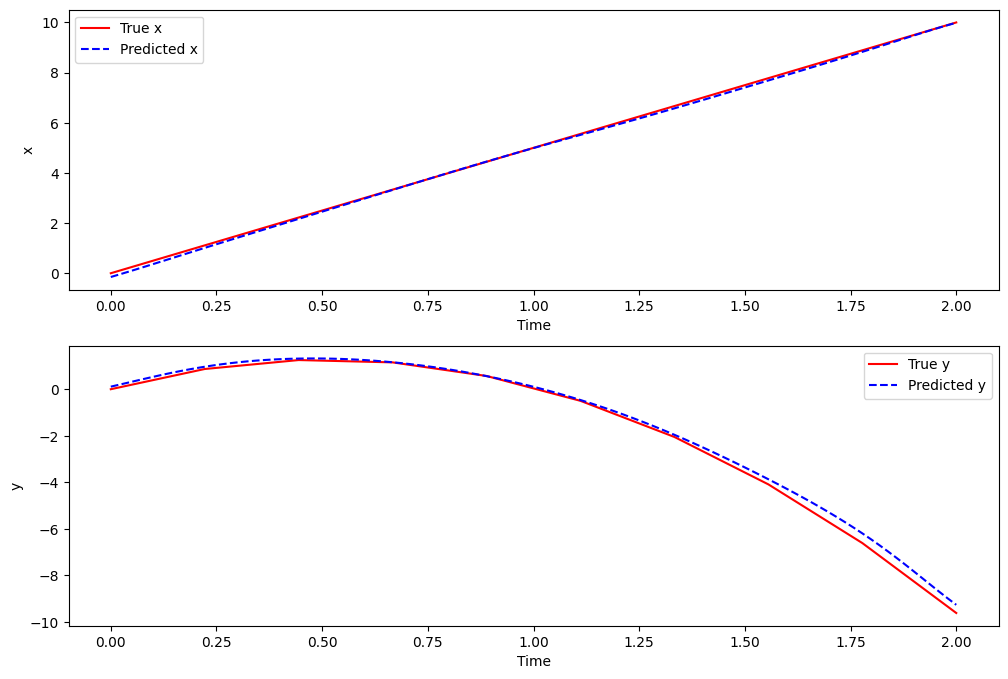

In [ ]:
import tensorflow as tf
import numpy as np
import time

class PhysicsInformedNN:
    def __init__(self, t, x, y, vx, vy, layers):
        self.lb = t.min()
        self.ub = t.max()

        self.t = t
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy

        self.layers = layers

        self.weights, self.biases = self.initialize_NN(layers)

        self.g = 9.81  # Gravity constant

        self.t_tf = tf.convert_to_tensor(self.t, dtype=tf.float32)
        self.x_tf = tf.convert_to_tensor(self.x, dtype=tf.float32)
        self.y_tf = tf.convert_to_tensor(self.y, dtype=tf.float32)
        self.vx_tf = tf.convert_to_tensor(self.vx, dtype=tf.float32)
        self.vy_tf = tf.convert_to_tensor(self.vy, dtype=tf.float32)

        self.optimizer_Adam = tf.optimizers.Adam()

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, t, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0 * (t - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_pinn(self, t):

        nn_output = self.neural_net(t, self.weights, self.biases)
        x = nn_output[:, 0:1]
        y = nn_output[:, 1:2]
        vx = nn_output[:, 2:3]
        vy = nn_output[:, 3:4]

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t)
            x = self.neural_net(t, self.weights, self.biases)[:, 0:1]
            y = self.neural_net(t, self.weights, self.biases)[:, 1:2]
            vx = self.neural_net(t, self.weights, self.biases)[:, 2:3]
            vy = self.neural_net(t, self.weights, self.biases)[:, 3:4]

        x_t = tape.gradient(x, t)
        y_t = tape.gradient(y, t)
        vx_t = tape.gradient(vx, t)
        vy_t = tape.gradient(vy, t)

        f_x = x_t - vx
        f_y = y_t - vy
        f_vx = vx_t
        f_vy = vy_t + self.g

        del tape

        return x, y, vx, vy, f_x, f_y, f_vx, f_vy

    def compute_loss(self):
        x_pred, y_pred, vx_pred, vy_pred, f_x_pred, f_y_pred, f_vx_pred, f_vy_pred = self.net_pinn(self.t_tf)

        loss = tf.reduce_mean(tf.square(self.x_tf - x_pred)) + \
               tf.reduce_mean(tf.square(self.y_tf - y_pred)) + \
               tf.reduce_mean(tf.square(self.vx_tf - vx_pred)) + \
               tf.reduce_mean(tf.square(self.vy_tf - vy_pred)) + \
               tf.reduce_mean(tf.square(f_x_pred)) + \
               tf.reduce_mean(tf.square(f_y_pred)) + \
               tf.reduce_mean(tf.square(f_vx_pred)) + \
               tf.reduce_mean(tf.square(f_vy_pred))
        return loss

    def train(self, nIter):
        start_time = time.time()
        for it in range(nIter):
            with tf.GradientTape() as tape:
                loss_value = self.compute_loss()
            grads = tape.gradient(loss_value, self.weights + self.biases)
            self.optimizer_Adam.apply_gradients(zip(grads, self.weights + self.biases))

            if it % 10 == 0:
                elapsed = time.time() - start_time
                print('It: %d, Loss: %.3e, Time: %.2f' %
                      (it, loss_value, elapsed))
                start_time = time.time()

    def predict(self, t_star):
        t_star_tf = tf.convert_to_tensor(t_star, dtype=tf.float32)
        nn_output = self.neural_net(t_star_tf, self.weights, self.biases)
        x_star = nn_output[:, 0:1]
        y_star = nn_output[:, 1:2]
        vx_star = nn_output[:, 2:3]
        vy_star = nn_output[:, 3:4]

        return x_star.numpy(), y_star.numpy(), vx_star.numpy(), vy_star.numpy()

# Generate training data for projectile motion
def generate_data():
    g = 9.81
    t = np.linspace(0, 2, 10)[:, None]
    x = 5 * t
    y = 5 * t - 0.5 * g * t**2
    vx = 5 * np.ones_like(t)
    vy = 5 - g * t
    return t, x, y, vx, vy

t_train, x_train, y_train, vx_train, vy_train = generate_data()

# Define the neural network layers
layers = [1, 20, 20, 4]

# Instantiate the PINN model
model = PhysicsInformedNN(t_train, x_train, y_train, vx_train, vy_train, layers)

# Train the model
model.train(1000)

# Predict the position and velocity at new time points
t_star = np.linspace(0, 2, 100)[:, None]
x_star, y_star, vx_star, vy_star = model.predict(t_star)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(t_train, x_train, 'r-', label='True x')
plt.plot(t_star, x_star, 'b--', label='Predicted x')
plt.xlabel('Time')
plt.ylabel('x')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_train, y_train, 'r-', label='True y')
plt.plot(t_star, y_star, 'b--', label='Predicted y')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend()

plt.show()


In [ ]:
import scipy
data = scipy.io.loadmat('cylinder_nektar_wake.mat')

In [ ]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X_star', 't', 'U_star', 'p_star'])

# Power systems

In [ ]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=74ef8c16c14b379d97159c9964a534b931d5b362e767340ba25040b5098b2cf8
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyDOE import lhs

np.random.seed(1234)
tf.random.set_seed(1234)

class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):

        self.lb = lb
        self.ub = ub

        self.x_u = X_u[:,0:1]
        self.t_u = X_u[:,1:2]

        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]

        self.u = u

        self.layers = layers
        self.nu = nu

        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)

        self.x_u_tf = tf.convert_to_tensor(self.x_u, dtype=tf.float32)
        self.t_u_tf = tf.convert_to_tensor(self.t_u, dtype=tf.float32)
        self.u_tf = tf.convert_to_tensor(self.u, dtype=tf.float32)

        self.x_f_tf = tf.convert_to_tensor(self.x_f, dtype=tf.float32)
        self.t_f_tf = tf.convert_to_tensor(self.t_f, dtype=tf.float32)

        self.optimizer_Adam = tf.optimizers.Adam()


    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x, t], 1), self.weights, self.biases)
        return u

    def net_f(self, x, t):
      with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        u = self.net_u(x, t)
        u_t = tape.gradient(u, t)[0]
        u_tt = tape.gradient(u_t, t)[0]
      f = 0.4*u_tt + 0.15*u_t + self.nu*tf.math.sin(u) - x
      return f

    def net_pinn(self, x, t):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t)
            u_pred = self.neural_net(tf.concat([x, t], 1), self.weights, self.biases)
            u_t = tape.gradient(u_pred, t)
            u_tt = tape.gradient(u_t, t)
        f_pred = 0.4*u_tt + 0.15*u_t + self.nu*tf.math.sin(u_pred) - x
        return u_pred, f_pred

    def compute_loss(self):
        u_pred, f_pred = self.net_pinn(self.x_u_tf, self.t_u_tf)
        loss = tf.reduce_mean(tf.square(self.u_tf - u_pred)) + tf.reduce_mean(tf.square(f_pred))
        return loss

    def train(self, nIter):
        start_time = time.time()

        for it in range(nIter):
            with tf.GradientTape() as tape:
                loss_value = self.compute_loss()
            grads = tape.gradient(loss_value, self.weights + self.biases)
            self.optimizer_Adam.apply_gradients(zip(grads, self.weights + self.biases))
            if it % 10 == 0:
                elapsed = time.time() - start_time
                print('It: %d, Loss: %.3e, Time: %.2f' % (it, loss_value, elapsed))
                start_time = time.time()

    def predict(self, X_star):
        X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)

        u_star = self.net_u(X_star_tf[:, 0:1], X_star_tf[:, 1:2])
        f_star = self.net_f(X_star_tf[:, 0:1], X_star_tf[:, 1:2])
        return u_star, f_star


In [ ]:
nu=0.2;
noise = 0.0

N_u = 40
N_f = 8000
layers = [2, 10, 10, 10, 10, 10, 1]

data = scipy.io.loadmat('swingEquation_inference.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]

# Domain bounds
lb=np.array([0.08 ,  0.        ])
ub=np.array([0.18,  20.        ])

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

start_time = time.time()
model.train(1000)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

start_time = time.time()
u_pred, f_pred = model.predict(X_star)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))

start_time = time.time()
u_pred, f_pred = model.predict(X_star)
U_pred = griddata(X_star, np.array(u_pred).flatten(), (X, T), method='cubic')
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

It: 0, Loss: 1.108e+00, Time: 1.99
It: 10, Loss: 7.447e-01, Time: 1.26
It: 20, Loss: 4.994e-01, Time: 1.40
It: 30, Loss: 3.301e-01, Time: 1.41
It: 40, Loss: 2.133e-01, Time: 1.61
It: 50, Loss: 1.416e-01, Time: 2.38
It: 60, Loss: 1.017e-01, Time: 2.13
It: 70, Loss: 8.111e-02, Time: 2.78
It: 80, Loss: 7.423e-02, Time: 1.35
It: 90, Loss: 7.343e-02, Time: 0.92
It: 100, Loss: 7.262e-02, Time: 0.63
It: 110, Loss: 7.137e-02, Time: 0.64
It: 120, Loss: 7.019e-02, Time: 0.66
It: 130, Loss: 6.896e-02, Time: 0.67
It: 140, Loss: 6.759e-02, Time: 0.65
It: 150, Loss: 6.603e-02, Time: 0.61
It: 160, Loss: 6.425e-02, Time: 0.65
It: 170, Loss: 6.222e-02, Time: 0.64
It: 180, Loss: 5.989e-02, Time: 0.64
It: 190, Loss: 5.723e-02, Time: 0.64
It: 200, Loss: 5.421e-02, Time: 0.86
It: 210, Loss: 5.080e-02, Time: 0.90
It: 220, Loss: 4.700e-02, Time: 0.95
It: 230, Loss: 4.286e-02, Time: 0.75
It: 240, Loss: 3.842e-02, Time: 0.68
It: 250, Loss: 3.382e-02, Time: 0.65
It: 260, Loss: 2.923e-02, Time: 0.62
It: 270, Los